# VDL-Mini-Challenge

Der Code für diese Mini-Challenge habe ich in externe Dateien ausgelagert. Dennoch werde ich hier in diesem Notebook den Code beschreiben und eine explorative Datenanalyse durchführen. Der beschriebene Code ist jeweils verlinkt. Auch habe ich hier Code der die Trainings und Evaluationsbefehle ausführt.

Aufgabe der Mini-Challenge ist das implementieren des Soft-Attention-Mechanismus aus dem [Show, Attend and Tell: Neural Image CaptionGeneration with Visual Attention](https://arxiv.org/pdf/1502.03044)-Paper.

Als Baseline-Modell habe ich das [Show and Tell: A Neural Image Caption Generator](https://arxiv.org/abs/1411.4555)-Paper (ohne Attention) verwendet.

Als Metrik zum die Performance zu evaluieren und vergleichen habe ich den BLEU-Score verwendet.

Zum trainieren der Modelle habe ich den Flickr8k-Datensatz verwendet. Als Decoder für das Bild habe ich VGG19 vortrainiert auf ImageNet1k verwendet. Und als Encoder habe ich ein LSTM verwendet.

Bei der Umsetzung habe ich viel mit PyTorch-Lightning gearbeitet. Dies nimmt einigen Code zum Trainieren der Modelle ab (z.B. Backprop im Trainingsloop).

# Explorative Datenanalyse
In diesem Teil des Notebook analysiere ich diverse Aspekte des Flickr8k-Datensatzes:
- Image size distribution
- Number of images and captions per image
- Caption length distribution
- Train/Val/Test split distribution
- Sample image visualization with captions

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import defaultdict
import wandb

In [ ]:
# Load the dataset
data_dir = os.path.join('..', 'data')
captions_file = os.path.join(data_dir, 'captions.txt')
images_dir = os.path.join(data_dir, 'Images')

# Read captions
df = pd.read_csv(captions_file)
print(f"Total number of caption entries: {len(df)}")
print(f"Number of unique images: {df['image'].nunique()}")

Total number of caption entries: 40455
Number of unique images: 8091


Der Flickr8k Datensatz besteht aus circa 8'000 Bildern von Flicker zu welchen jeweils 5 Captions (also Total 40k Captions) von Menschen geschrieben wurden.

## Train/Val/Test Split Distribution

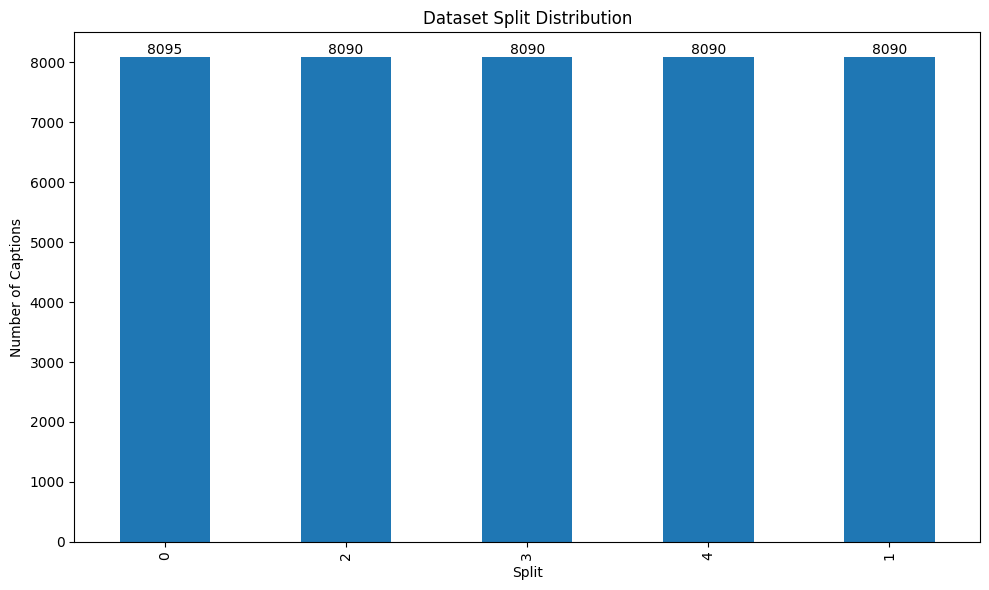


Split Percentages:
0: 20.01%
2: 20.0%
3: 20.0%
4: 20.0%
1: 20.0%


In [ ]:
# Plot split distribution
plt.figure(figsize=(10, 6))
split_counts = df['fold'].value_counts()
split_counts.plot(kind='bar')
plt.title('Dataset Split Distribution')
plt.xlabel('Split')
plt.ylabel('Number of Captions')
for i, v in enumerate(split_counts):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Print percentages
split_percentages = (split_counts / len(df) * 100).round(2)
print("\nSplit Percentages:")
for split, percentage in split_percentages.items():
    print(f"{split}: {percentage}%")

Um für die Validierung respektive das Testing Daten zu verwenden, welche das Model während dem Training noch nicht gesehen hat, habe ich mich für einen 80-10-10 train-val-test Split entschieden. Dabei war es wichtig, darauf zu achten, dass kein Bild in mehreren Splits vorkommt. Deshalb habe ich den Split auf Bildebene durchgeführt. Dies wird in der Daten `src/data/prepare_dataset.py` durchgeführt. Damit ich auch ein 5-fold Cross-Validation durchführen kann, habe ich den Datensatz in 5 Folds geteilt und halbiere jeweils einen Fold für die Evaluation und das Testing. Dass dies gelungen ist, kann man daran sehen, dass sich die Counts der Captions in jedem Fold durch 5 Teilen lassen.

## Image Size Distribution

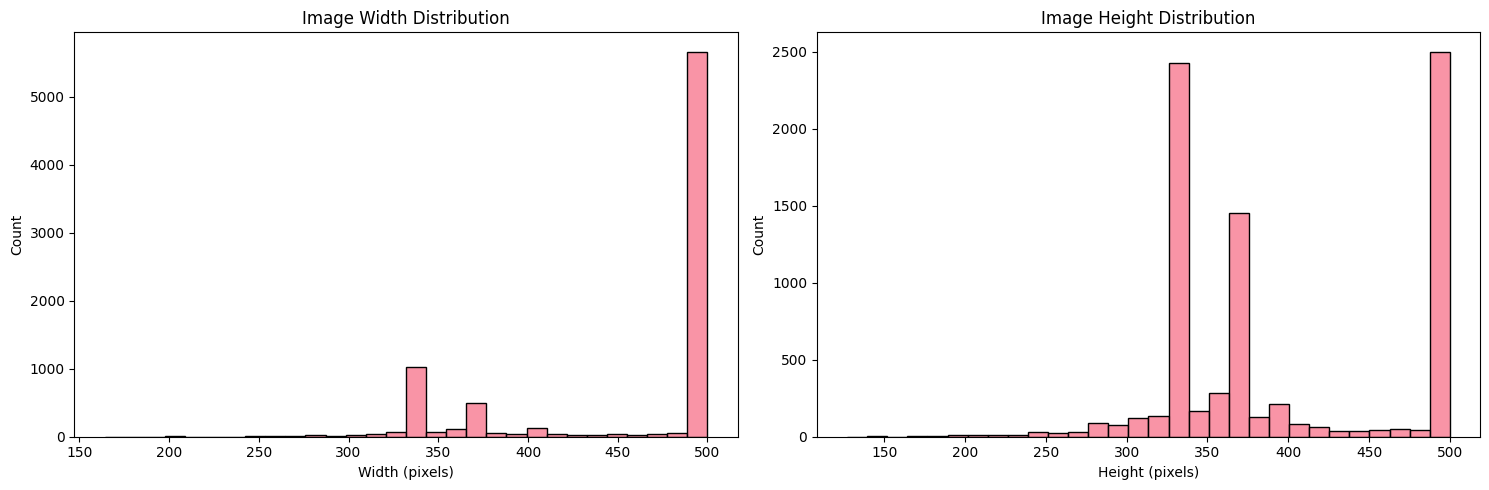


Average image dimensions: 458x397 pixels
Median image dimensions: 500x375 pixels


In [ ]:
# Analyze image sizes
image_sizes = []
for img_name in df['image'].unique():
    img_path = os.path.join(images_dir, img_name)
    if os.path.exists(img_path):
        with Image.open(img_path) as img:
            width, height = img.size
            image_sizes.append((width, height))

widths, heights = zip(*image_sizes)

# Create subplots for width and height distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(widths, bins=30, ax=ax1)
ax1.set_title('Image Width Distribution')
ax1.set_xlabel('Width (pixels)')

sns.histplot(heights, bins=30, ax=ax2)
ax2.set_title('Image Height Distribution')
ax2.set_xlabel('Height (pixels)')

plt.tight_layout()
plt.show()

print(f"\nAverage image dimensions: {np.mean(widths):.0f}x{np.mean(heights):.0f} pixels")
print(f"Median image dimensions: {np.median(widths):.0f}x{np.median(heights):.0f} pixels")

Hier ist die Vertielung der Bildgrösser zu sehen. Aufgeteilt in Bildbreite und Bildhöhe. Es hat fast keine kleinen Bilder und die Bilder wurden bereits auf eine maximale Grösse von 500x500 zugeschnitten. Ansonsten befindet sich hier nicht viel spannendes.

## Caption Analysis

In [ ]:
# Analyze captions per image
captions_per_image = df['image'].value_counts()

print("Distribution of Captions per Image:")
print(captions_per_image.value_counts().sort_index())

print(f"\nAverage captions per image: {captions_per_image.mean():.2f}")
print(f"Median captions per image: {captions_per_image.median():.2f}")

Distribution of Captions per Image:
count
5    8091
Name: count, dtype: int64

Average captions per image: 5.00
Median captions per image: 5.00


Hier die Bestätigung, dass alle Bilder wirklich genau 5 Captions haben. Nicht mehr und nicht weniger.

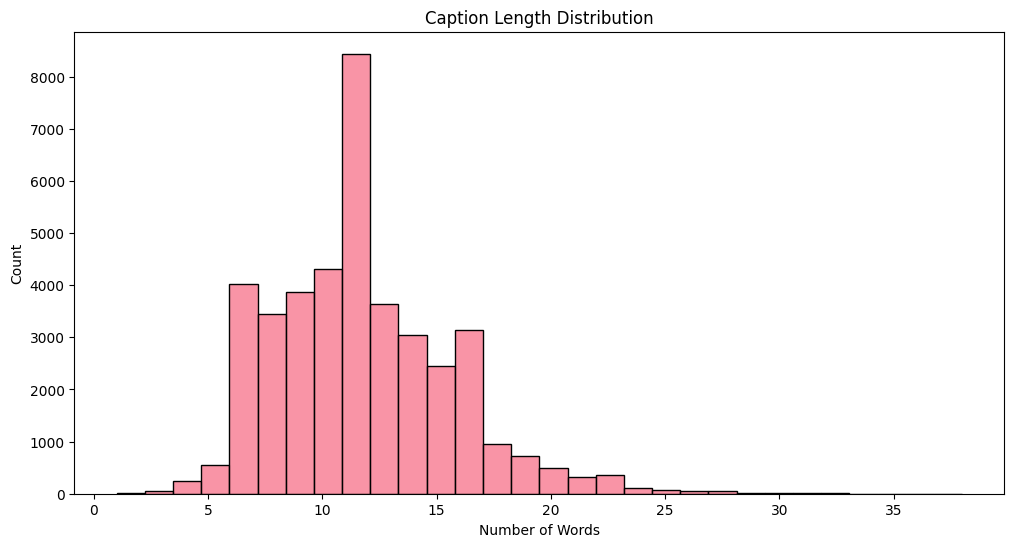

Average caption length: 11.78 words
Median caption length: 11.00 words
Min caption length: 1 words
Max caption length: 38 words

Number of captions longer than 20 words: 1033
Percentage of captions longer than 20 words: 2.55%

Percentage of images with 3 or fewer captions of max 20 words: 0.06%


In [ ]:
# Analyze caption lengths
df['caption_length'] = df['caption'].str.split().str.len()

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='caption_length', bins=30)
plt.title('Caption Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Count')
plt.show()

print(f"Average caption length: {df['caption_length'].mean():.2f} words")
print(f"Median caption length: {df['caption_length'].median():.2f} words")
print(f"Min caption length: {df['caption_length'].min()} words")
print(f"Max caption length: {df['caption_length'].max()} words")

# Count captions longer than 20 words
long_captions = df[df['caption_length'] > 20]
print(f"\nNumber of captions longer than 20 words: {len(long_captions)}")
print(f"Percentage of captions longer than 20 words: {(len(long_captions) / len(df) * 100):.2f}%")

# Calculate percentage of images with 3 or fewer captions that have max length of 20 words
df_filtered = df[df['caption_length'] <= 20]
captions_per_image_filtered = df_filtered['image'].value_counts()
images_with_few_captions = captions_per_image_filtered[captions_per_image_filtered <= 2]

total_images = len(df['image'].unique())
percent_few_captions = (len(images_with_few_captions) / total_images) * 100

print(f"\nPercentage of images with 3 or fewer captions of max 20 words: {percent_few_captions:.2f}%")



Hier zu sehen ist die Verteilung der Länge der Captions. Die kürzeste Caption ist ein Wort lang und die längste 38 Wörter. Beim Training begrenze ich die Captions auf 20 Wörter. Dies betrift 2.55% aller Captions was eher wenig ist und daher vertretbar. Wenn ich die volle Länge trainieren würde, würde dies den Task a) viel schwieriger machen, b) mehr Ressourcen brauchen, und c) hätte ich dann wohl schnelchtere Resultate. Durch Abschneiden der Captions nach 20 Wörter haben dann 0.06% der Bilder nur noch 2 oder 1 Caption welche weniger als 20 Captions haben => heisst, wir haben für fast alle Bilder mindestens 2 Captions welche nicht abgeschnitten werden.

## Sample Image with Captions

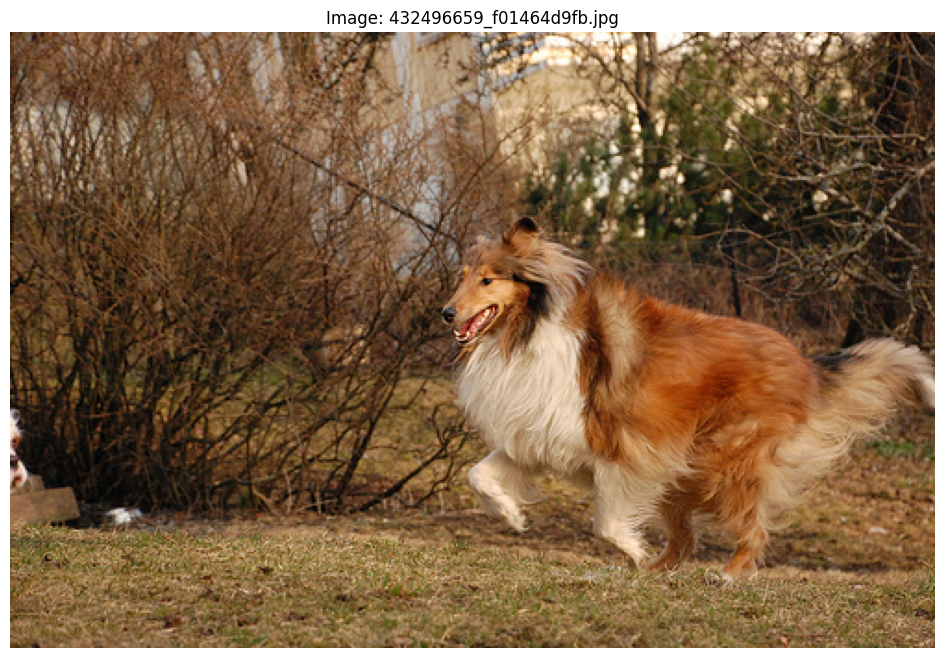

Captions:
1. a brown and white dog is walking through some wasteland .
2. A collie runs across a yard in the springtime .
3. A Collie surrounded by leafless bushes .
4. A dog that looks like Lassie walking in the fields .
5. The dog is in front of some bushes .


In [ ]:
# Display a random image with its captions (with fixed seed)
np.random.seed(42)  # Set seed for reproducibility
random_image = np.random.choice(df['image'].unique())
image_captions = df[df['image'] == random_image]['caption'].tolist()

plt.figure(figsize=(12, 8))
img = Image.open(os.path.join(images_dir, random_image))
plt.imshow(img)
plt.axis('off')
plt.title(f'Image: {random_image}')
plt.show()

print("Captions:")
for i, caption in enumerate(image_captions, 1):
    print(f"{i}. {caption}")

Hier zu sehen ist ein zufälliges Bild aus dem Datensatz mit den 5 Captions. Die Captions zeigen eine Mischung aus präzisen und ungenauen Beschreibungen. Während einige Captions relevante Details wie die Rasse des Hundes und die Umgebung gut einfangen, sind andere entweder zu allgemein oder enthalten falsche Beschreibungen (z. B. "Wasteland", "some bushes" oder "fields"). Dies deutet darauf hin, dass die Qualität der Captions inkonsistent ist, wobei manche besser geeignet sind, den Kontext des Bildes klar und akkurat wiederzugeben.

# Beschreibung des Codes

## Data Loader

### Datensatz vorbereiten
Der Datensatz wird im [src/data/prepare_dataset.py](src/data/prepare_dataset.py) direkt von Kaggle heruntergeladen. Anschliessend werden die Captions (gruppiert nach dem Bild) in 5 Folds aufgeteilt. Beim Training werden dann jeweils 4 Folds zum Training verwendet und der übriggebliebene Fold wird deterministisch in zwei geteilt für Validation und Testing. Damit erreiche ich einen 80/10/10 Split.

Gleichzeitig wird noch ein Vokabular für jeden Fold erstellt. Für jeden Fold, weil ein Modell keine Tokens lernen kann welche nur im Val/Test vorkommen (keine positiven Trainingsdaten). Dort werden jeweils Wörter weggelassen welche weniger als 3 mal vorkommen im Trainingsdatensatz. Damit wird das Modell nicht so gross und die zu lernende Aufgabe ein bisschen einfacher. Auch habe ich die Caption-Länge begrenzt (auf 20 Tokens/Wörter) um einen effizienten Umgang mit den Computer-Ressourcen zu finden (siehe Collate-Kapitel).

### Datensatz laden
Im [src/data/dataset.py](src/data/dataset.py) werden die Bilder beim Laden wie folgt transformiert, damit sie möglichst den Eigenschaften des Datensatzes (ImageNet_1k) entsprechen, welcher zum Vortrainieren von VGG19 verwendet wurden:
- Resize auf die Grösse 224x224
- Normalisieren auf `Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`

Beim Laden der Captions werden diese in Tokens umgewandelt. Die Tokenization ist einfach und jedes Wort entspricht einem Wort. Es gibt auch noch komplexere Tokenization wie Byte-Pair-Encoding (BPE) welche durch das Aufteilen in Wortteile die Captions effizienter repräsentieren können. Unbekannte Wörter werden durch das `<unk>` Token ersetzt. Des Weiteren beginnt jeder Caption mit dem `<start>`-Token und endet mit dem `<end>`-Token. Tokens sind ID's welche den Index des Klassifikations-Logits angeben und dann wieder in ein Wort umgewandelt werden können.

#### Collate
Damit beim Trainieren gebrauch von Batches gemacht werden kann müssen die einzelnen Datenpunkte zusammengefügt werden. Dies nennt sich collating. Bei Bilder können die Tensoren gestacked werden, da sie alle die gleiche Grösse haben. Bei Captions ist dies schwieriger, aufgrund der unterschiedlichen Länge. Hier müssen alle Captions am Ende mit padding-Tokens (`<pad>`) aufgefüllt werden, sodass sie die gleiche Länge wie die längste Caption im Batch haben. Es wird dann immernoch die Prediction für die Padding-Tokens berechnet, aber beim Loss ignoriert.

## Training

Der Trainingscode befindet sich in [src/train.py](src/train.py). Es gibt zwei Debug-Modes. Beide evaluieren nicht so viel und sparen damit Zeit beim entwickeln. Auch trainieren sie nur mit einem sehr kleinen Teil der Daten um zu testen ob es Fehler in der Logik des Codes hat und ob das Modell auf den wenigen Daten lernt/overfittet. 


### Parameter
Über die CLI können folgende Argumente mitgegeben werden:
- `model`: welches der beiden implementierten Modelle
- `checkpoint_dir`: ob weights von dort geladen werden sollen (Training weiterfahren).
- `embed_size`: Wieviele Dimensionen für das Embedding der Wörter verwendet wird. (Bei mir immer: 256)
- `hidden_size`: Hidden dim von LSTM. (Bei mir immer: 512)
- `attention_dim` Dimension des Attention-Layer im "Show, Attend, Tell" Modell. (Bei mir immer: 256) 
- `batch_size` Wieviele Datenpunkte in einem Batch sind (Bei mir immer: 32)
- `epochs` Wieviele Epochen trainiert wird (Bei mir immer: 10)
- `grad_clip` Über welchen Wert der Gradient Clipped wird. Um Exploding Gradients zu vermeiden (Bei mir immer: 5)
- `num_workers` Wieviele Workers gleichzeitig die Daten laden (Bei mir immer: 4)
- `eval_fold` Welcher Fold für Validation und Test verwendet wird.
- `debug` Welcher Debugmodus


### Checkpoints
Ich verwende zwei Checkpoints:
- Einen um die besten 3 Checkpoints zu speichern gemäss dem minimalen Validation-Loss
- Und einen um den letzten Checkpoint zu speichern.

Jeweils am Ende des Trainings wird der beste Checkpoint (gemäss min. Val-Loss) auf WandB hochgeladen.

## Modelle

### Basismodell/Common Methods
In der Datei [src/models/base_model.py](src/models/base_model.py) ist Code zu finden, den beide Modelle teilen. Dort wird der VGG19-Decoder geladen. Auch befindet sich dort Code um Visualisierungen zu erstellen und zu loggen (Visualisierung der Attention für jedes Token). Implementiert werden müssen jewils die Funktionen `forward` und `generate_caption`. 

Beide Modelle verwenden ein LSTM mit einer Dropout-Rate von 0.5 und einem einzigen Linearen Layer welcher die Outputs vom LSTM direkt in den Vocabulary Space transformiert für die Predictions. Initialisiert werden die Hidden-Sates mit den Features des VGG-Decoders.

Gelernt werden die Modelle mit dem State-of-the-Art optimizer ADAM und Teacher-Forcing (jeweils nur den nächsten Token vorhersagen und nicht Vorhersagen für die nächste Vorhersage verwenden, sondern durch die Ground-Truth dieses Tokens ersetzen). CrossEntropyLoss wird zum Berechnen des Losses verwendet. Dieser eignet sich für Klassifikations-Tasks mit mehr als zwei Klassen.

Das generieren der Captions ist bei der Quantitativen-Evaluation beschrieben.



### Show and Tell
In der Datei [src/models/show_and_tell.py](src/models/show_and_tell.py) ist der Code zu finden, welcher das "Show and Tell"-Modell darstellt.

Input für das LSTM-Netzwerk sind die Features vom VGG-Decoder und die Embedded Captions.



### Show, Attend, and Tell
In der Datei [src/models/show_attend_tell.py](src/models/show_attend_tell.py) ist der Code zu finden, welcher das "Show, Attend, and Tell"-Modell darstellt. Der Unterschied ist zum "Show and Tell"-Modell ist die Einbindung von Attention welche weiter unten genau beschrieben ist.

Input für das LSTM-Netzwerk sind die Features vom VGG-Decoder, Attention-Map und die Embedded Captions.


### VGG19
Ist ein deep-NN und setzt sich aus 16 CNN-Layer und 3 fully-connected Layern zusammen. Charakteristisch für diese Architektur ist, dass sich die Seitenlänge der Feature-Volumens halbiert (durch eine Max-Pool-Operation mit Stride=2), sich aber dafür die Tiefe (Anzahl Channels) verdoppelt. Das Netzwerk verwendet nur 3x3 Kernels und ReLU-Activations. Im folgenden Bild ist der genaue Aufbau zu sehen: 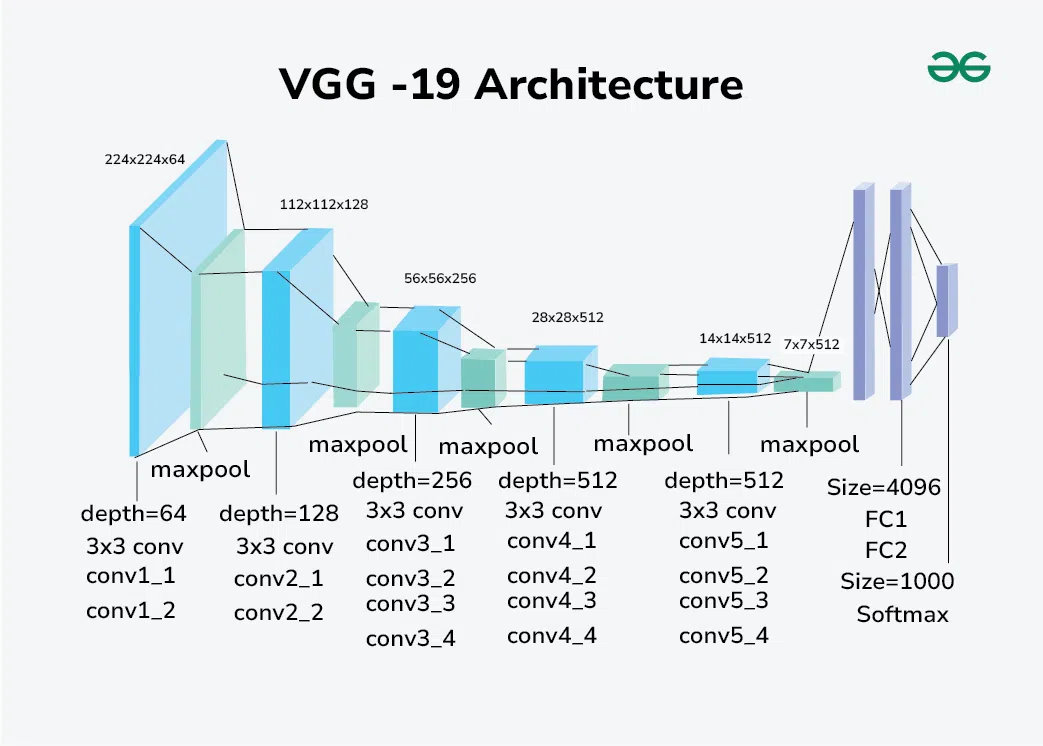. Der letzte der drei fully-connected NN-Layers wird bei meinem Modellen weggelassen da er die 1000 Klassen vorhersagt, welche beim Vortrainieren verwendet wurden. Diese sind aber nicht mehr relevant für mich, da ich mich nur für die Repräsentation des Bildes in diesem 4096-Dimensionalen Vektor interesseiere. Dieser wird dann weiter an das LSTM gegeben.


VGG-19 hat andere Architekturen wie ResNet inspiriert durch den Gebrauch von uniformen Kernels und der Tiefe des Modells. Es wird viel für Transfer-Learning (wie z.B. hier) verwendet.


### LSTM
LSTMs sind eine Art von Recurrent-Neuronalen-Netzwerken, welche gleich zwei hidden States haben: long-term und short-term. 
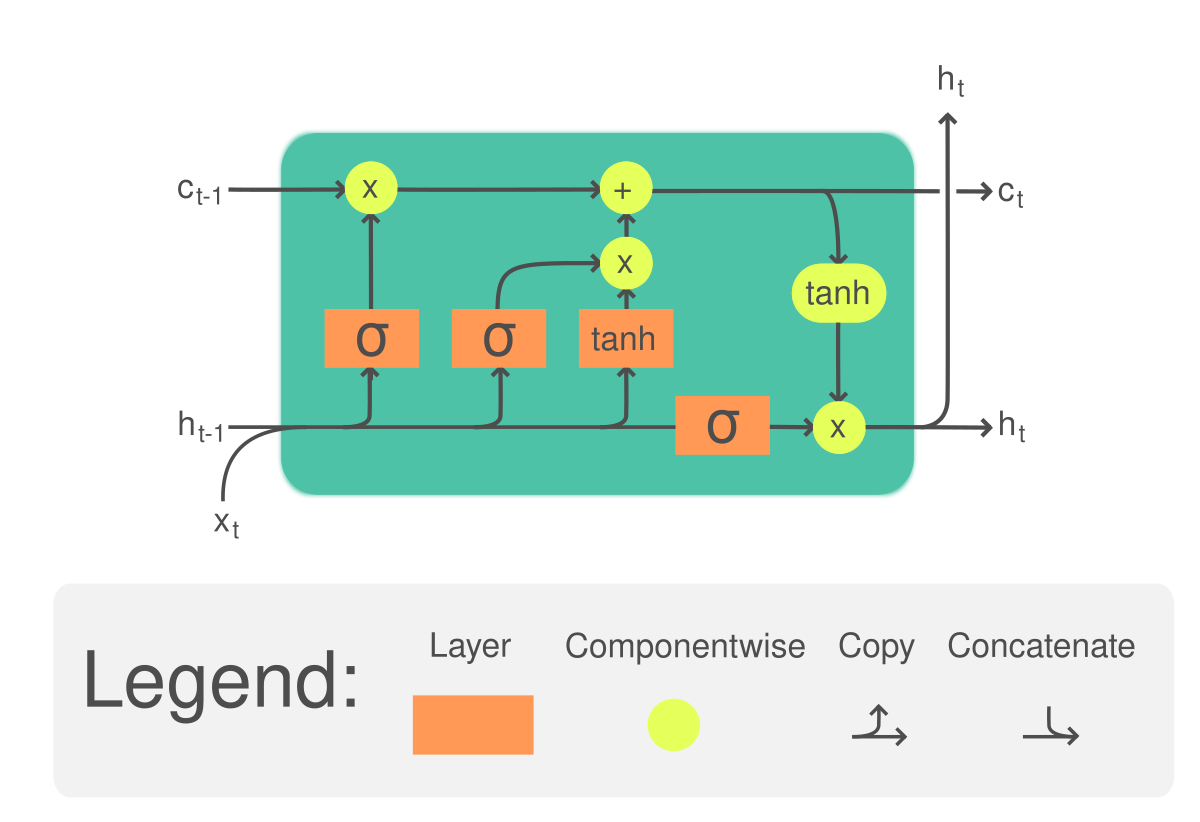
Im Bild oben ist eine einzige Cell eines LSTM's zusehen. Die erste Multiplikation von links bildet das Forget-Gate, welches entscheiden ob das Long-Term-Memory $c_t$ gelöscht werden soll. Die zweite Multiplikation bildet das Input-Gate um das Long-Term-Memory zu aktualisieren und die dritte Multiplikation bildet das Output-Gate welches das Long-Term-Memory und Short-Term-Memory kombiniert und den Output für den nächsten LSTM-Layer oder die Klassifikation liefert.

Es gibt noch andere Arten von RNNs (z.B. GRU) aber um meine Resultate möglichst vergleichbar zu behalten, habe ich den gleichen Encoder wie das Attention-Paper gewählt.



### Attention Machanismus

Das Herzstück des "Show, Attend, Tell" Paper ist die Implementierung von Attention. Im Paper sind zwei Arten von Attention beschrieben (Hard und Soft). Ich fokusiere mich aber hier nur auf Soft-Attention. Der implementierte Soft-Attention Mechanismus basieren die Autoren direkt auf Bahdanau et al. (2014). Das Konzept von Attention ist von der Funktionsweise des Sehens des Menschen inspiriert. Der Mensch kann sich auch nicht auf alles in einem Bild gleichzeitig fokusieren. Er fokusiert sich auf einen bestimmten Teil im Bild und wandert dann weiter zu einem anderen Ort. Ähnlich funktioniert Attention, für jeden Token der predicted werden soll wird eine Attention-Map generiert welches das Modell auf einen bestimmten Ort auf dem Bild lenken soll, der wichtig für das nächste Token ist.

Ein Vorteil von Attention auf Bildern ist, dass diese visualiert werden kann und so das Modell auf eine neue Weise qualitativ evaluiert werden kann.

Die implementierte Softattention nach Bahdanau ist eine Cross-Attention welche zwischen dem Encoder-Output (VGG19 7x7 Feature Map mit 512 hidden dimensions) und dem Decoder-Hidden-State (LSTM). Sie unterscheidet sich duetlich von der Attention welche in Transformers verwendet werden (mit Key, Query, Values). Die Implementierung ist in [src/models/show_attend_tell.py](src/models/show_attend_tell.py) zu finden.

$$
score = v^T tanh(W_1 h_i + W_2 s_t)
$$
$$
α = softmax(score)
$$
$$
context = Σ α_i h_i
$$

Wobei:
- $h_i$: encoder outputs (7x7x512 image features)
- $s_t$: decoder hidden state (vom LSTM)
- $W_1, W_2$: zu lernende Weight-Matrizen
- $v^T$: zu lernender Vektor
- $a_i$: die Alphas welche vorgeben, welcher Teil des Bildes wichtig ist für das nächste Token.


Auch wird auf Zeile 122 in [src/models/show_attend_tell.py](src/models/show_attend_tell.py) einer Regularisierung der Alphas auf 1 durchgeführt. Damit wird der Attention-Machanismus robuster. Und auf Zeile 98 wird Attention Gating durchgeführt. Somit haben die Alphas auf jedem Channel einen unterschiedlichen Einfluss.


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from collections import defaultdict

# Training der Modelle
Das Training (5-Fold Cross-Validation) kann durch folgenden Befehl ausgeführt werden (die 10 Trainingsbefehle wurden aneinandergekettet).

In [4]:
cmds = []
for model in ["show_tell", "show_attend_tell"]:
    for fold in range(5):
        cmd = f"python src/train.py --model {model} --checkpoint_dir {model}_fold{fold} --eval_fold {fold} --epochs 10"
        print(cmd)
        cmds.append(cmd)


print("\nChained Commands:")
print(" && ".join(cmds))

python src/train.py --model show_tell --checkpoint_dir show_tell_fold0 --eval_fold 0 --epochs 10
python src/train.py --model show_tell --checkpoint_dir show_tell_fold1 --eval_fold 1 --epochs 10
python src/train.py --model show_tell --checkpoint_dir show_tell_fold2 --eval_fold 2 --epochs 10
python src/train.py --model show_tell --checkpoint_dir show_tell_fold3 --eval_fold 3 --epochs 10
python src/train.py --model show_tell --checkpoint_dir show_tell_fold4 --eval_fold 4 --epochs 10
python src/train.py --model show_attend_tell --checkpoint_dir show_attend_tell_fold0 --eval_fold 0 --epochs 10
python src/train.py --model show_attend_tell --checkpoint_dir show_attend_tell_fold1 --eval_fold 1 --epochs 10
python src/train.py --model show_attend_tell --checkpoint_dir show_attend_tell_fold2 --eval_fold 2 --epochs 10
python src/train.py --model show_attend_tell --checkpoint_dir show_attend_tell_fold3 --eval_fold 3 --epochs 10
python src/train.py --model show_attend_tell --checkpoint_dir show_atte

Die Produzierten Modellartefakte sind im folgenden Dictionary abgespeichert um die Evaluation Commands zu generieren. Der abgespeicherte Checkpoint wurde jeweils mit Early Stopping ausgewählt (Minimierung des Validation-Losses; Paper verwendet Early-Stopping auf BLEU-Score, aber nicht klar welchen). Aus dem folgenden Validation-Loss Chart geht hervor, dass die Modelle schon jeweils nach 10 Epochen overfitten (ansteigender Validation-Loss).

![W&B Chart 1_12_2025, 10_27_32 PM.png](<attachment:W&B Chart 1_12_2025, 10_27_32 PM.png>)
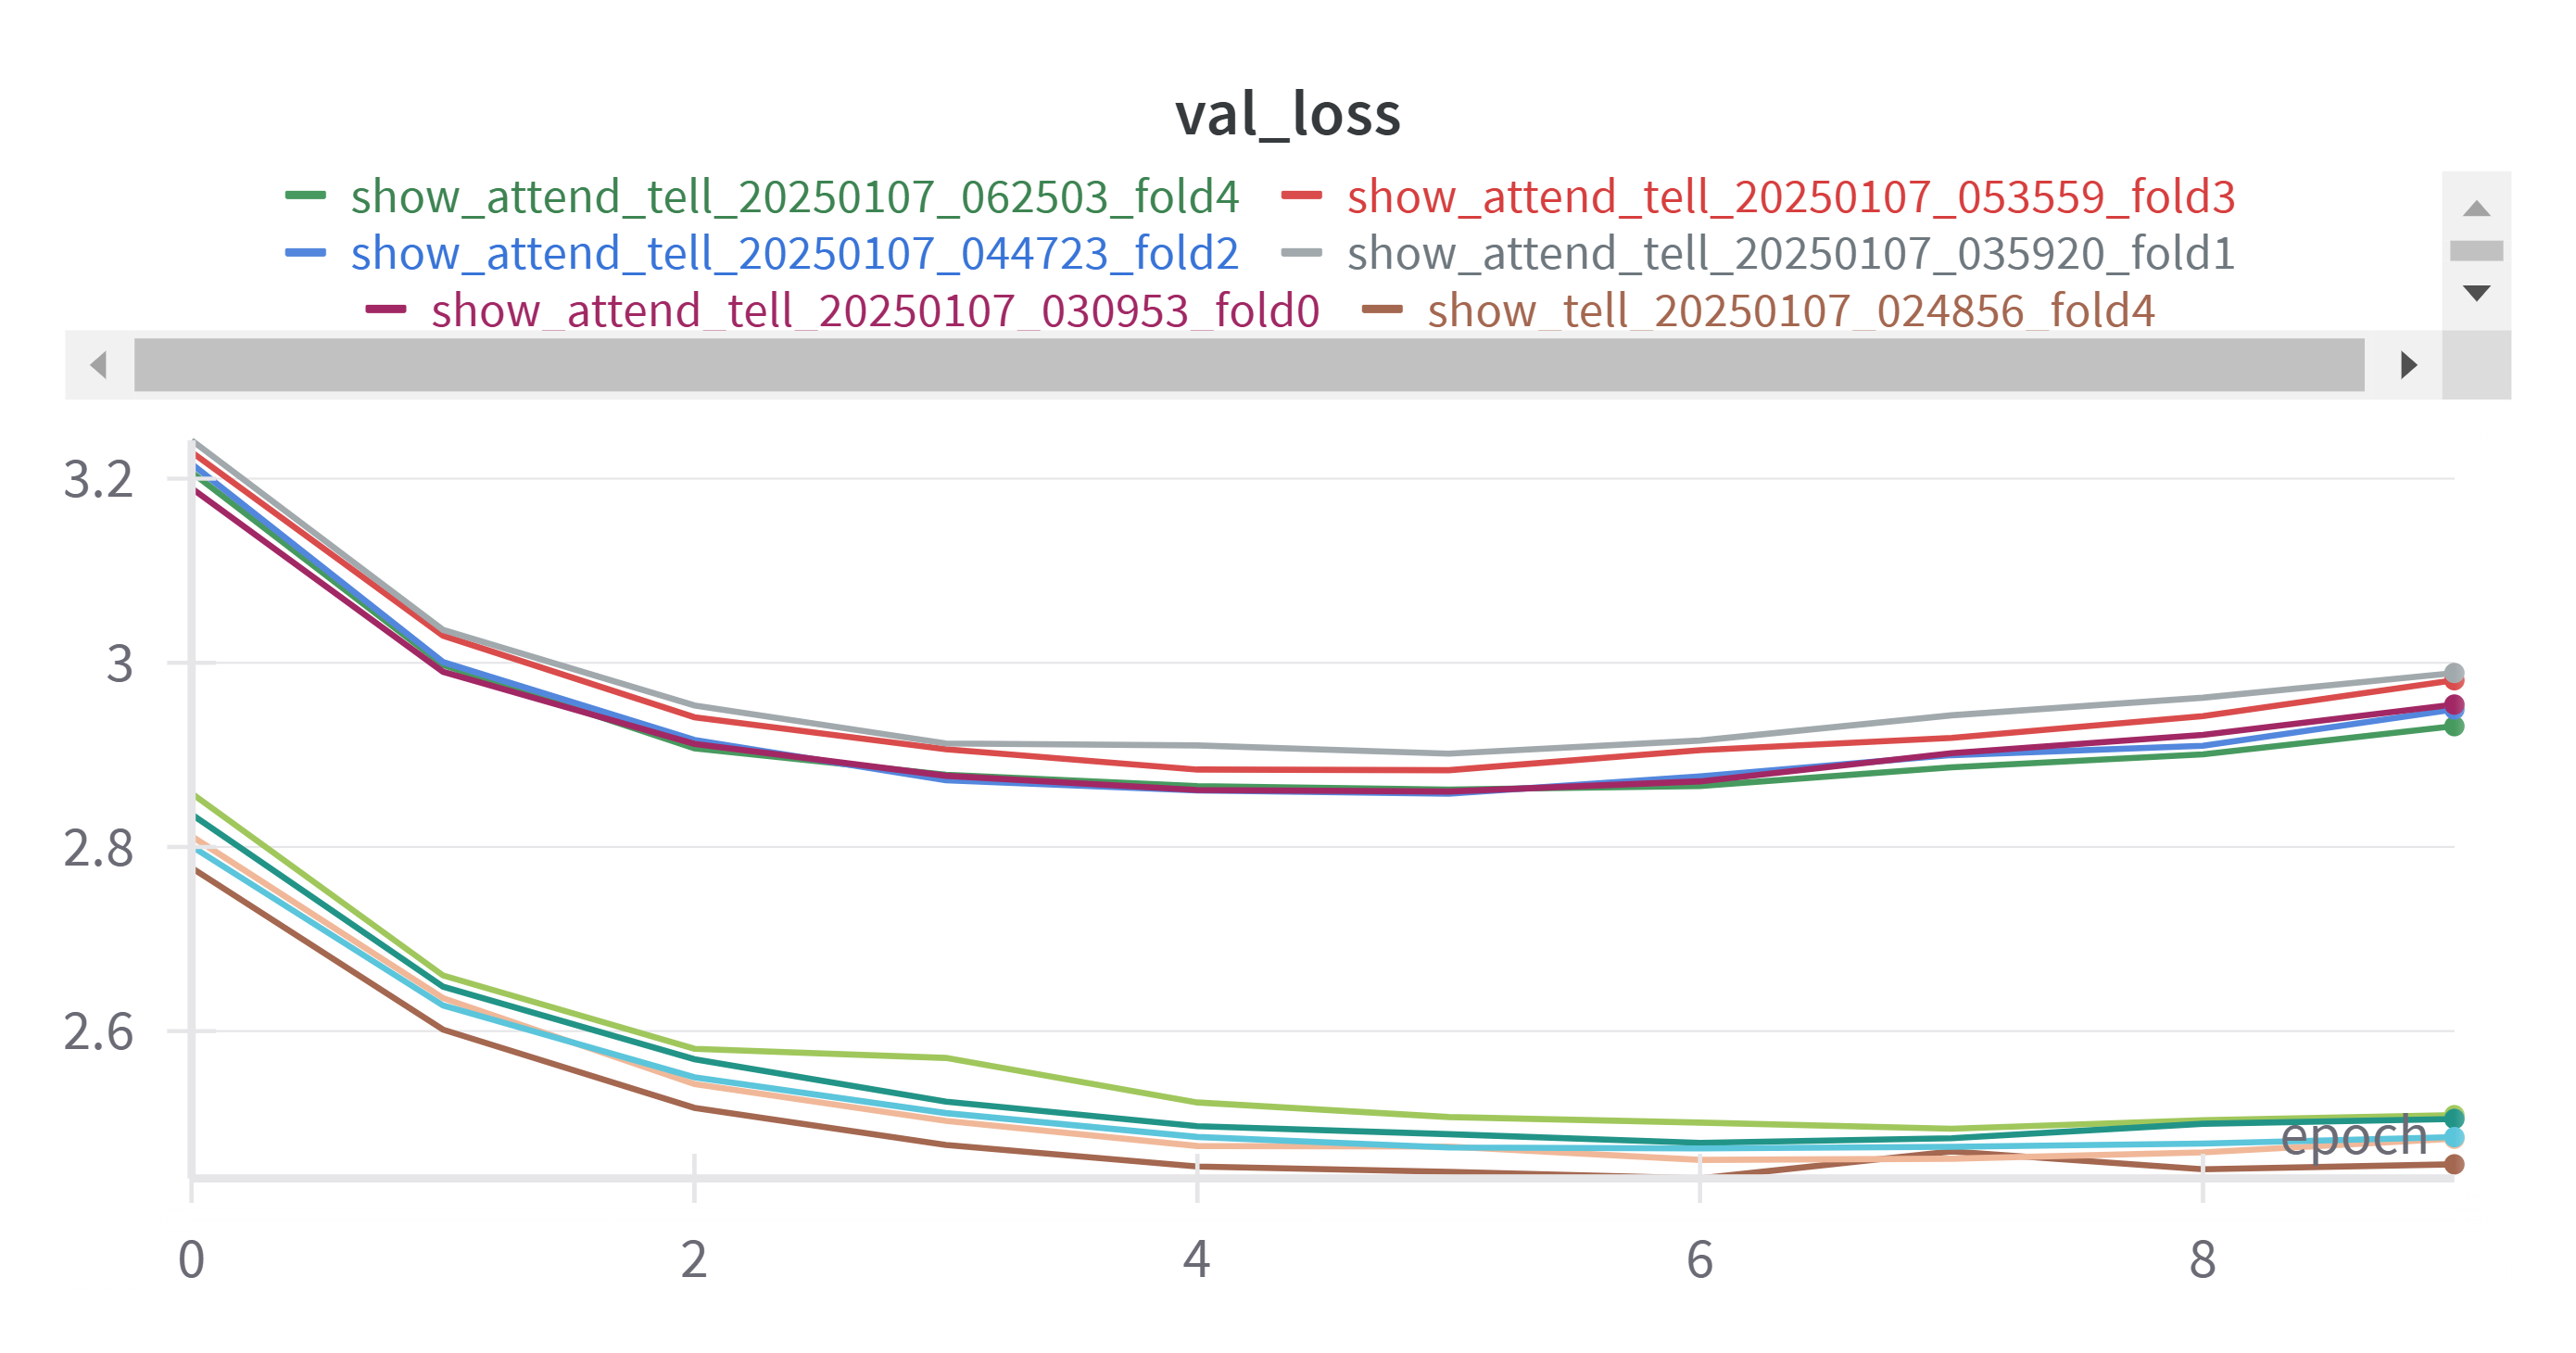

In [5]:
# model checkpoint artefacts generated during 5-fold cv trained using commands from above 
model_artefacts = {
    "show_tell": {
        0: "model-show_tell_20250107_012408_fold0:v0",
        1: "model-show_tell_20250107_014557_fold1:v0",
        2: "model-show_tell_20250107_020657_fold2:v0",
        3: "model-show_tell_20250107_022823_fold3:v0",
        4: "model-show_tell_20250107_024856_fold4:v0"
    },
    "show_attend_tell": {
        0: "model-show_attend_tell_20250107_030953_fold0:v0",
        1: "model-show_attend_tell_20250107_035920_fold1:v0",
        2: "model-show_attend_tell_20250107_044723_fold2:v0",
        3: "model-show_attend_tell_20250107_053559_fold3:v0",
        4: "model-show_attend_tell_20250107_062503_fold4:v0"
    }
}

# Evaluation der Modelle

Auch hier habe ich wieder die 10 Befehle der Evaluation der Modelle erstellt und seperate in einer Konsole evaluieren lassen. Die Modelle werden auf den unbenutzten Testdaten evaluiert. Die Validierungsdaten wurden ja schon zur Auswahl des Checkpoints verwendet. 

In [6]:
# evaluate each artefact using the following command
# python eval.py --model [show_tell/show_attend_tell] --eval_fold [fold] --wandb_project image-captioning-comparison --wandb_artifact [artifact_name:version]
cmds = []
for model_name, folds in model_artefacts.items():
    for fold, artifact in folds.items():
        cmd = " ".join(["python", "eval.py", "--model", model_name, "--eval_fold", str(fold), "--wandb_project", "image-captioning-comparison", "--wandb_artifact", artifact])
        print(cmd)
        cmds.append(cmd)


print("\nChained Commands:")
print(" && ".join(cmds))

python eval.py --model show_tell --eval_fold 0 --wandb_project image-captioning-comparison --wandb_artifact model-show_tell_20250107_012408_fold0:v0
python eval.py --model show_tell --eval_fold 1 --wandb_project image-captioning-comparison --wandb_artifact model-show_tell_20250107_014557_fold1:v0
python eval.py --model show_tell --eval_fold 2 --wandb_project image-captioning-comparison --wandb_artifact model-show_tell_20250107_020657_fold2:v0
python eval.py --model show_tell --eval_fold 3 --wandb_project image-captioning-comparison --wandb_artifact model-show_tell_20250107_022823_fold3:v0
python eval.py --model show_tell --eval_fold 4 --wandb_project image-captioning-comparison --wandb_artifact model-show_tell_20250107_024856_fold4:v0
python eval.py --model show_attend_tell --eval_fold 0 --wandb_project image-captioning-comparison --wandb_artifact model-show_attend_tell_20250107_030953_fold0:v0
python eval.py --model show_attend_tell --eval_fold 1 --wandb_project image-captioning-compa

Hier habe ich die entstandenen run_ids wieder in einem Dictionary zusammengefasst um eine Auswertung der Testmetriken machen zu können.

In [7]:
results = {
    "show_tell": {
        0: "v7o350sb",
        1: "86dr1hfe",
        2: "pl0pdryz",
        3: "xj4hhys9",
        4: "l2fxfljm"
    },
    "show_attend_tell": {
        0: "l9ti2727",
        1: "rv1d3nhp",
        2: "s3arun67",
        3: "u2maw7nc",
        4: "u6gvher4"
    }
}

In [8]:
api = wandb.Api()

# Initialize an empty list to store logs
all_logs = []

# Iterate through the results to fetch logs for each model and fold
for model_name, folds in results.items():
    for fold, run_id in folds.items():
        # run is specified by <entity>/<project>/<run_id>
        run = api.run(f"florin-barbisch/image-captioning-comparison/runs/{run_id}")

        # Fetch the logs for beam_bleu1
        logs = run.history()
        # Remove test_attention_comparison column if it exists
        if 'test_attention_comparison' in logs.columns:
            logs = logs.drop('test_attention_comparison', axis=1)
        logs = logs.drop(['_step', '_timestamp', '_runtime'], axis=1)
            
        # Drop rows with any NaN values
        logs = logs.dropna()

        # Adding model and fold columns to the DataFrame
        logs['model'] = model_name
        logs['fold'] = fold
        
        # Append the logs to the list
        all_logs.append(logs)

# Concatenate all logs into one big DataFrame
final_logs_df = pd.concat(all_logs, ignore_index=True)

final_logs_df.sample(5)

True
True
True
True
True
True
True
True
True
True


,beam_bleu4,beam_bleu2,beam_bleu1,greedy_bleu4,greedy_bleu1,greedy_bleu2,beam_bleu3,greedy_bleu3,model,fold
1,2.943411,12.033919,27.815485,3.333721,29.208190,13.141051,5.584594,6.272646,show_tell,1
5,23.014137,46.130817,65.911432,19.323275,61.869313,42.027353,32.816416,28.929363,show_attend_tell,0
6,21.515930,45.621513,65.827675,19.958961,63.630449,43.640017,31.948714,30.053048,show_attend_tell,1
0,2.349674,11.070336,26.583963,2.395733,26.274515,10.253199,4.918598,4.647314,show_tell,0
8,20.917201,44.181150,64.598214,18.238447,62.065718,41.583792,30.699419,27.744321,show_attend_tell,3


In [9]:

# Identify beam and greedy columns
beam_cols = [col for col in final_logs_df.columns if col.startswith('beam_')]
greedy_cols = [col for col in final_logs_df.columns if col.startswith('greedy_')]

# Create separate dataframes for beam and greedy metrics
beam_df = final_logs_df[['model', 'fold'] + beam_cols].copy()
greedy_df = final_logs_df[['model', 'fold'] + greedy_cols].copy()

# Rename columns to remove prefixes
beam_df.columns = ['model', 'fold'] + [col.replace('beam_', '') for col in beam_cols]
greedy_df.columns = ['model', 'fold'] + [col.replace('greedy_', '') for col in greedy_cols]

# Add mode column
beam_df['mode'] = 'beam'
greedy_df['mode'] = 'greedy'

# Combine and melt the dataframes
final_melted_df = pd.concat([beam_df, greedy_df])
final_melted_df = final_melted_df.melt(
    id_vars=['model', 'fold', 'mode'],
    var_name='metric',
    value_name='score'
)

final_melted_df.sample(5)

,model,fold,mode,metric,score
21,show_tell,1,beam,bleu2,12.033919
44,show_tell,4,beam,bleu1,39.332834
48,show_attend_tell,3,beam,bleu1,64.598214
65,show_attend_tell,0,beam,bleu3,32.816416
70,show_tell,0,greedy,bleu3,4.647314


## Quantitativ

Hier evaluiere ich die quantitative Leistung meiner Modelle. Konkret über den BLEU-Score.

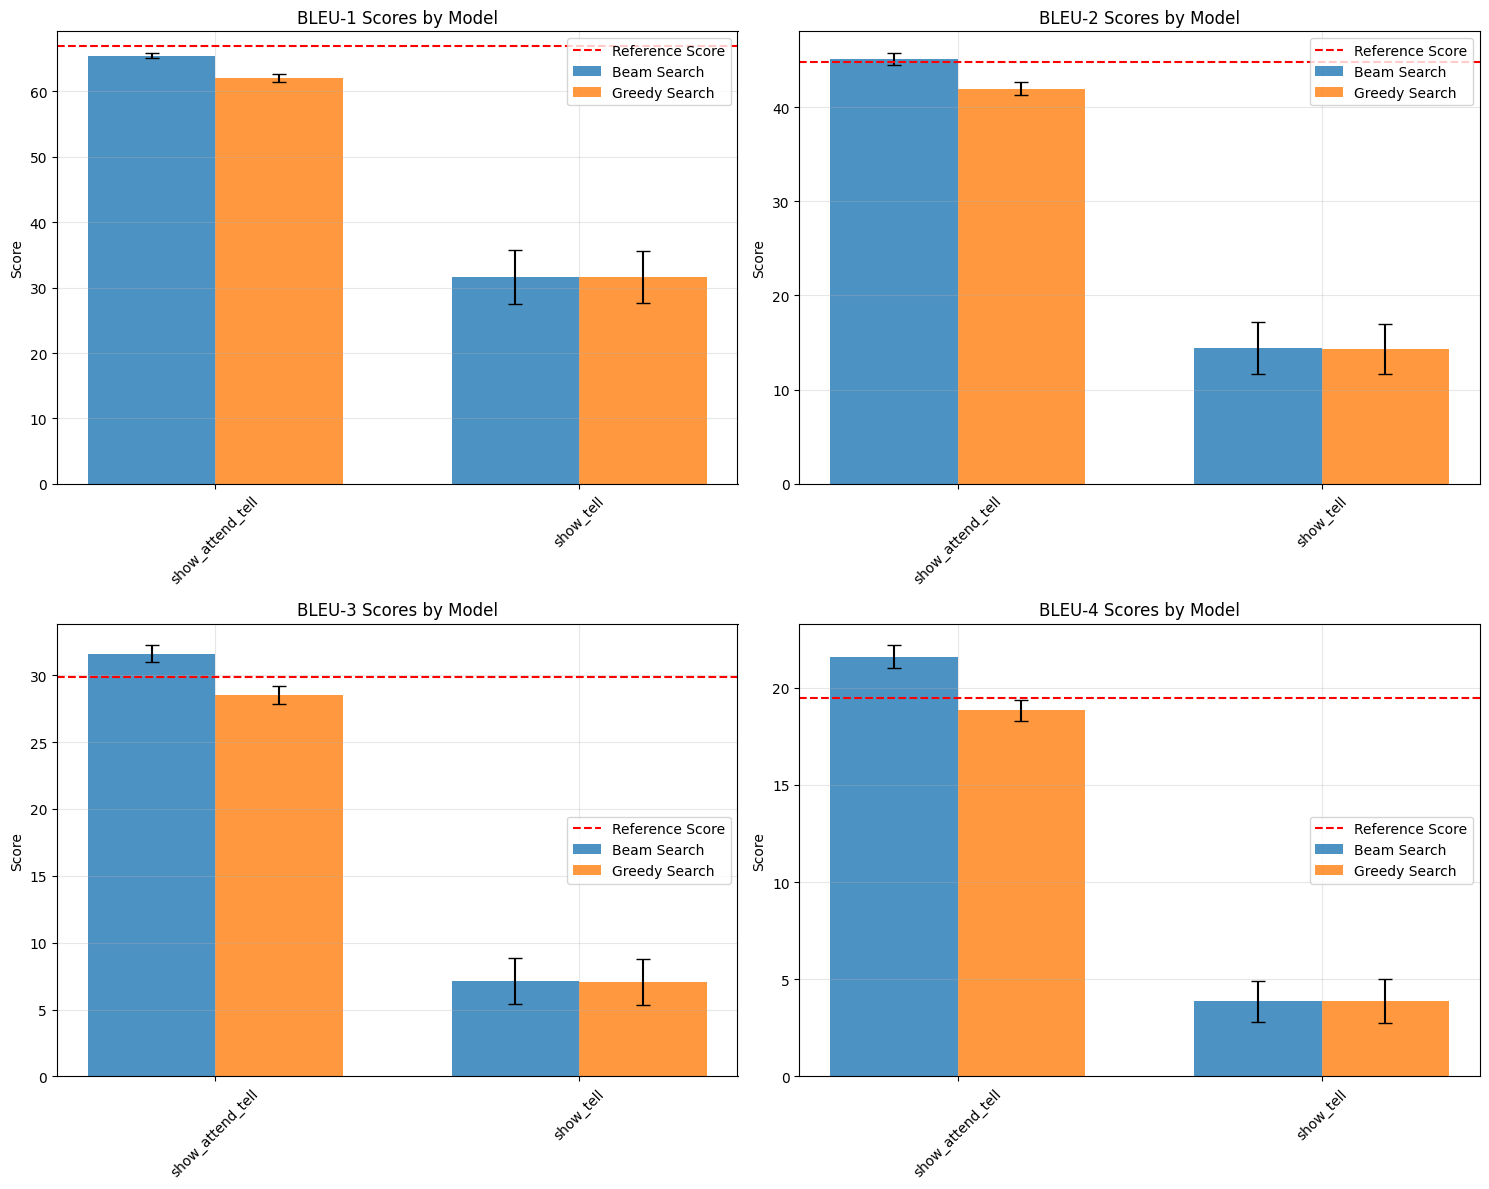

In [12]:
# Reference scores from show_attend_tell paper (Softattention on Flickr8k)
reference_scores = {
    'bleu1': 67.0,
    'bleu2': 44.8, 
    'bleu3': 29.9,
    'bleu4': 19.5
}

# Create figure with 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

# Plot each BLEU score
for idx, metric in enumerate(['bleu1', 'bleu2', 'bleu3', 'bleu4']):
    # Calculate mean and std for each model/mode combination
    plot_data = final_melted_df[final_melted_df['metric'] == metric].groupby(['model', 'mode'])['score'].agg(['mean', 'std']).reset_index()
    
    # Plot bars with error bars
    x = np.arange(len(plot_data['model'].unique()))
    width = 0.35
    
    beam_data = plot_data[plot_data['mode'] == 'beam']
    greedy_data = plot_data[plot_data['mode'] == 'greedy']
    
    axes[idx].bar(x - width/2, beam_data['mean'], width, yerr=beam_data['std']/np.sqrt(len(beam_data)), 
                 label='Beam Search', capsize=5, alpha=0.8)
    axes[idx].bar(x + width/2, greedy_data['mean'], width, yerr=greedy_data['std']/np.sqrt(len(greedy_data)),
                 label='Greedy Search', capsize=5, alpha=0.8)
    
    # Add reference line
    axes[idx].axhline(y=reference_scores[metric], color='r', linestyle='--', 
                     label='Reference Score')
    
    # Customize plot
    axes[idx].set_title(f'BLEU-{metric[-1]} Scores by Model')
    axes[idx].set_xticks(x)
    axes[idx].set_xticklabels(plot_data['model'].unique(), rotation=45)
    axes[idx].set_ylabel('Score')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Im obenstehenden Plot sind 4 Grafiken zu finden, welche alle das gleiche darstellen. Nur für jeweils einen anderen BLEU-Score. Auf der Y-Achse ist jeweils der Score abgebildet und auf der X-Achse die beiden Modelle ('Show and Tell' sowie 'Show, Attend, Tell'). Die rote gestrichelte horizontale Linie beschreibt die Referenzwerte des 'Show, Attend, Tell'-Modell aus dem Paper 'Show, Attend and Tell: Neural Image Caption Generation with Visual Attention' auf dem gleichen Datensatz (Flickr8k).

Die Modelle haben immer zwei Säulen (blau und Orange). Die blaue Säule ist Beam Search und die Orange Greedy Search. Die Unsicherheitsbalken geben den Standardfehler an: $\frac{std}{\sqrt{n}}$. 

Den Grafiken ist zu entnehmen, dass ich in BLEU-2 die Referenz-Scores mit meinem 'Show, Attend, Tell'-Modell erreicht habe und bei BLEU-3 und 4 sogar übertroffen habe. Bei BLEU-1 habe ich den Referenz-Score knapp nicht erreicht. Beam-Serarch ist immer deutlich besser als Greedy-Search bei meinem 'Show, Attend, Tell'-Modell. Das 'Show and Tell'-Modell ist deutlich schlechter, was sich durch die fehlende Attention erklären lässt. Referenz-Scores habe ich leider keine gefunden. Der Unterschied zwischen Greedy und Beam-Search ist nicht mehr sichtbar. 




**Was ist Beam-Search und was ist Greedy-Search?**

Die autoregressiven Modelle welche ich implementiert habe, generieren aus einem Bild eine Sequenz an Tokens. Beim auswählen des nächsten Tokens (Decoding) gibt es zwei verschiedene Arten:
- Greedy-Search: der nächste Token wird durch das maximale Logit gegeben. Simple Klassifikation.
- Beam-Search: es werden die Top-$n$ Tokens genommen und für jedes dieser $n$-Tokens wird eine Klassifikation des nächsten Tokens durchgeführt. Von all diesen Klassifikationen werden jeweils wieder die Top-$n$ Klassifikationen/Tokens ausgewählt (durch multiplizieren der Logits dieser Vorhersage-Kette), usw. So exploriert das Modell gleichzeitig mehrere vielversprechende Wege und erzielt bessere Ergebnisse als Greedy-Search. Dieser Ansatz bevorzugt kürzere Sätze durch das multiplizieren der Logits (logits <= 1; Produkt wird mit mehr logits immer kleiner). Dem wird aber entgegengewirkt durch das Length-Penalty welches kürzere Sätze bestraft. Die Beam-Size (wieviele Top-$n$ Resultate bevorzugt werden) war bei meiner Evaluation 3.

Die IMplementierung beider Algorithmen ist in den Dateien  [src/models/show_and_tell.py](src/models/show_and_tell.py) und [src/models/show_attend_tell.py](src/models/show_attend_tell.py) zu finden. Der Code unterscheidet sich, weil bei einem Modell Attention verwendet wurde und beim anderen nicht.



**Was ist der BLEU-Score?**

Der BLEU-Score (Bilingual Evaluation Understudy) ist eine verbreitete Metrik zur Bewertung der Qualität von maschinell übersetzten Texten. Im Zusammenhang mit Image-Caption-Generation wird sie zur Bewertung der Qualität der generierten Captions im Vergleich zu den 5 Referenz-Captions verwendet. Der BLEU-Score wird durch n-Gram Precision berechnet:


$$
\text{BLEU} = \text{BP} \cdot \exp\left(\sum_{n=1}^{N} w_n \log p_n\right)
$$

Wobei:
- $p_n$ Precision der n-Grams.
- $w_n$ Gewichtung der n-Gram Grösse (normalerweise uniform sowie bei mir auch).
- $\text{BP}$ Brevity-Penalty, calculated as:
  - $\text{BP} = 1$ wenn die generierte Caption länger als die Referenz-Caption ist.
  - $\text{BP} = e^{(1 - \text{Referenz-Caption-Länge} / \text{generierte Caption-Länge})}$ falls die generierte Caption kürzer als die Referenz-Caption ist.
Ein höherer BLEU-Score bekommt man, wenn die generierte Caption besser zur Referenz-Caption passt. Was auf eine höhere Qualität der Beschreibung hindeutet. Im Kontext von Machine-Translation erreichen Menschen Scores zwischen 0.6 und 0.7. Also ein Score von 1 ist unwahrscheinlich und wesentlich kleinere Werte sind schon sehr gut.

N-Grams sind einfach Gruppierungen von Tokens: BLEU-4: basiert auf 4-Grams. Es werden immer 4 Tokens zusammengefasst und werden als ein neues Token behandelt in der Berechnung.

Ein Nachteil von BLEU ist, dass er nur auf Precision fokusiert und den Recall ignoriert. Abhilfe dazu würde die Metrik ROUGE schaffen, welche auf dem Recall von n-Grams basiert. Die Metrik METEOR (welche auch im Attention-Paper verwendet wird) balanciert beide Ansätze (Recall und Precision).


Auch berücksichtigt BLEU die semantische Ähnlichkeit von Wörtern nicht. Dafür würden sich Metriken wie BERT-Score eignen, welche die Tokens zuerst in den semantischen Raum von BERT transformieren und so semantische Ähnlichkeiten abbilden können.



**Hat meine Reduktion des Dictionary einen Einfluss auf den BLEU-Score?**

Damit das Modell nicht zu viele Tokens lernen muss welche nur 1-3 vorkommen, habe ich diese aus dem Vokabular gestrichen und durch `<unk>` ersetzt (dem Token für unbekannte Wörter). Wenn das Modell vorher vielleicht mühe gehabt hätte den richtigen Begriff vorherzusagen, dann ist jetzt die Chance viel grösser, dass es `<unk>` richtig vorhersagt. Somit wird der Task der zu lernen ist einfacher und damit auch alle Metriken besser. Inklusive BLEU-Score. Diese Reduktion ist im Paper nicht zu finden.

## Qualitativ

TODO:
- vgl vers generierter Captions.